In [3]:
# Import the data from chainer_chemistry

from chainer_chemistry import datasets
from chainer_chemistry.dataset.preprocessors.ggnn_preprocessor import GGNNPreprocessor

from __future__ import print_function
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import AllChem

from ipywidgets import interact
import numpy as np
import pandas as pd 
import seaborn as sns 
from scipy.stats import linregress

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\shaza\miniconda3\lib\site-packages\chainer_chemistry\__init__.py:8: UserWarning: A module chainer_chemistry.datasets was not imported, probably because RDKit is not installed. To install RDKit, please follow instruction in https://github.com/pfnet-research/chainer-chemistry#installation.
  warnings.warn(


ImportError: No module named 'sklearn.__check_build._check_build'
___________________________________________________________________________
Contents of C:\Users\shaza\miniconda3\lib\site-packages\sklearn\__check_build:
_check_build.cp311-win_amd64.pyd__init__.py               __pycache__
___________________________________________________________________________
It seems that scikit-learn has not been built correctly.

If you have installed scikit-learn from source, please do not forget
to build the package before using it: run `python setup.py install` or
`make` in the source directory.

If you have used an installer, please check that it is suited for your
Python version, your operating system and your platform.

In [4]:
pip install sklearn 

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [15 lines of output]
  The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
  rather than 'sklearn' for pip commands.
  
  Here is how to fix this error in the main use cases:
  - use 'pip install scikit-learn' rather than 'pip install sklearn'
  - replace 'sklearn' by 'scikit-learn' in your pip requirements files
    (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
  - if the 'sklearn' package is used by one of your dependencies,
    it would be great if you take some time to track which package uses
    'sklearn' instead of 'scikit-learn' and report it to their issue tracker
  - as a last resort, set the environment variable
    SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
  
  More information is available at
  https://github.com/scikit-learn/sklearn-pypi-package
  [end of output]
  
  note: This error originates from a subpr

In [5]:
label_names = datasets.get_qm9_label_names()
print('QM9 label names = ',label_names)

NameError: name 'datasets' is not defined

In [4]:
preprocessor = GGNNPreprocessor()
dataset, dataset_smiles = datasets.get_qm9(preprocessor, labels=None, return_smiles=True)

100%|████████████████████████████████████████████████████████████████████████| 133885/133885 [00:36<00:00, 3644.14it/s]
C:\Users\shaza\AppData\Roaming\Python\Python310\site-packages\chainer_chemistry\dataset\parsers\data_frame_parser.py:151: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  feat_array = numpy.asarray(feature)


In [5]:
print('dataset information...')
print('dataset', type(dataset), len(dataset))

print('smiles information...')
print('dataset_smiles', type(dataset_smiles), len(dataset_smiles))

dataset information...
dataset <class 'chainer_chemistry.datasets.numpy_tuple_dataset.NumpyTupleDataset'> 133885
smiles information...
dataset_smiles <class 'numpy.ndarray'> 133885


In [6]:
# code to help render the molecules 

def moltosvg(mol,molSize=(450,150),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return svg

def render_svg(svg):
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    return SVG(svg.replace('svg:',''))


smiles: C#CC#CC(N)=O


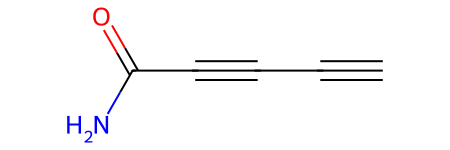

In [7]:
# render a random compound
index = 1200

smiles = dataset_smiles[index]
mol = Chem.MolFromSmiles(dataset_smiles[index])

print('smiles:', smiles)
svg = moltosvg(mol)
render_svg(svg)

In [8]:
# visualise the compounds in QM9 dataset

np.set_printoptions(precision=3, suppress=True)

def show_dataset(index):
    print('index={}, SMILES={}'.format(index, dataset_smiles[index]))
    atom, adj, labels = dataset[index]
    print('atom', atom)
    # print('adj', adj)
    print('labels', labels)
    mol = Chem.MolFromSmiles(dataset_smiles[index])
    return render_svg(moltosvg(mol))

interact(show_dataset, index=(0, len(dataset) - 1, 1))

interactive(children=(IntSlider(value=66942, description='index', max=133884), Output()), _dom_classes=('widge…

<function __main__.show_dataset(index)>

In [9]:
# begin the tasks for data preparation...

# create a list of smiles strings
smiles_list = [dataset_smiles[index] for index in range(len(dataset))]

# create a list of labels
labels_list = [dataset[index][2].tolist() for index in range(len(dataset))]

In [10]:
# create a list of mols
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

# create a list of fingerprints from mols
fps = [Chem.RDKFingerprint(mol) for mol in mols]

In [115]:
## fingerprint as bit vector (morgan->ECFP)
radius = 2
n_bits = 32
morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol,radius,n_bits)
bit_vector = morgan_fp.ToBitString()

# create a list of Morgan fingerprints from smile strings
fingerprint_vec = [AllChem.GetMorganFingerprintAsBitVect(mol,radius,n_bits).ToBitString() for mol
                  in mols]

In [116]:
fingerprint_vec[0]

'00000000000000001000000000000000'

In [117]:
# create an empty list and then array for storing fingerprints
empty_list = []

for i in range(len(fingerprint_vec[0])):
    finger_list = []
    for j in range(len(fingerprint_vec)):
        finger_list.append(float(fingerprint_vec[j][i]))
    empty_list.append(finger_list)
    
fingerprint_array = np.array(empty_list)

In [118]:
norm_data_array = np.array(labels_list).T

# Normalize the 15 properties
for i in range(len(norm_data_array)):
    
    norm_data_array[i] = (norm_data_array[i] - np.min(norm_data_array[i]))/(np.max(norm_data_array[i]) - np.min(norm_data_array[i]))

norm_data_array_T = np.array(norm_data_array.T)   

# create a dictionary of smiles v/s properties 
data_smiles = {}
for i in range(len(norm_data_array_T)):
    data_smiles[smiles_list[i]] = norm_data_array_T[i]

<Axes: >

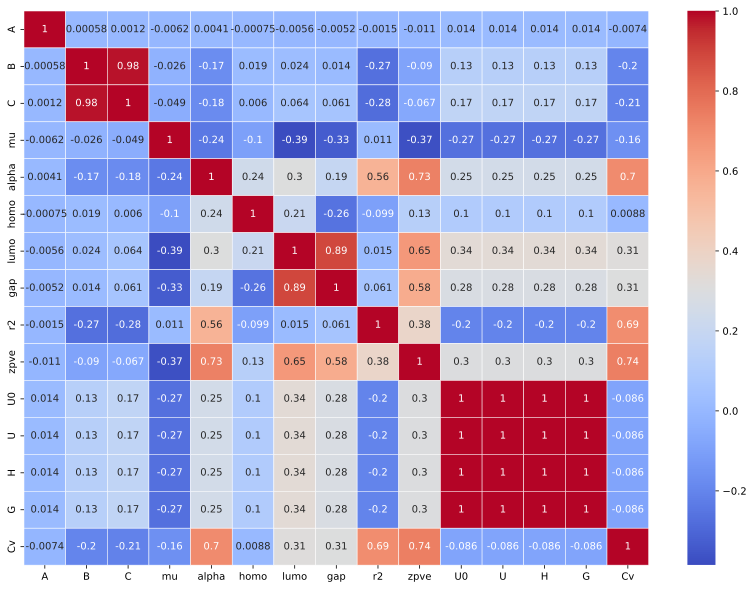

In [119]:
# visualise the correlations
df = pd.DataFrame(data_smiles)
df = df.T
df.columns = label_names
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=.5)

In [120]:
# visualise the data in a dataframe including the bit vectors

fingerprint_array_T = fingerprint_array.T

empty_dict = {}
for i in range(15):
    empty_dict[label_names[i]] = np.array(labels_list).T[i]
    
df = pd.DataFrame(empty_dict)

columns = [str(i) for i in range(n_bits)]
array_df = pd.DataFrame(fingerprint_array_T, columns=columns)

df = pd.concat([df,array_df],axis=1)

df.index = smiles_list

df['Fingerprint_vectors'] = fingerprint_vec

df.head()

,A,B,C,mu,alpha,homo,lumo,gap,r2,zpve,...,23,24,25,26,27,28,29,30,31,Fingerprint_vectors
C,157.711807,157.709976,157.706985,0.0000,13.210000,-0.3877,0.1171,0.5048,35.364101,0.044749,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00000000000000001000000000000000
N,293.609741,293.541107,191.393967,1.6256,9.460000,-0.2570,0.0829,0.3399,26.156300,0.034358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00100000000000000000000000000000
O,799.588135,437.903870,282.945465,1.8511,6.310000,-0.2928,0.0687,0.3615,19.000200,0.021375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00000000000000000000001000000000
C#C,0.000000,35.610035,35.610035,0.0000,16.280001,-0.2845,0.0506,0.3351,59.524799,0.026841,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,00000000000000000001000000000001
C#N,0.000000,44.593884,44.593884,2.8937,12.990000,-0.3604,0.0191,0.3796,48.747601,0.016601,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00000000110000000001000000000000


In [121]:
df['Fingerprint_vectors'][0]

'00000000000000001000000000000000'

## Regression Task

### predicting 3 out of 15 properties using bit vectors as inputs

In [16]:
# method 1: take bit vectors + 12 properties as inputs while the remaining 3 as output labels but it reveals the 
# identity of the molecules and make a biased prediction 

# data = np.vstack((norm_data_array[:12,:],fingerprint_array))
# label = norm_data_array[12:15,:]

In [17]:
# method 2: take bit vectors as input while any 3 out of 15 labels as output labels 

bit_vector_data = fingerprint_array
predicting_labels = norm_data_array[3:6]   # we are taking properties 3 to 5 as labels 

In [18]:
# create the data loaders
data = torch.tensor(bit_vector_data.T).float()
labels = torch.tensor(predicting_labels.T).float()

train_data,test_data,train_labels,test_labels = train_test_split(data,labels,test_size=0.2)

train_data = TensorDataset(train_data,train_labels)
test_data = TensorDataset(test_data,test_labels)

batchsize = 50
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [19]:
# create a regression based deep learning model that takes 1024 bit vectors as input and give 3 properties as output

def createTheRegNet():
    
    class RegNet(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.input = nn.Linear(1024,100)
            
            self.fc1 = nn.Linear(100,100)
            self.fc2 = nn.Linear(100,100)
            
            self.output = nn.Linear(100,3)
            
        def forward(self,x):
            
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return self.output(x)
        
    net = RegNet()
        
    lossfun = nn.MSELoss()
        
    optimizer = torch.optim.Adam(net.parameters(),lr=0.001,weight_decay=.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',verbose=True,patience=5)
        
    return net,lossfun,optimizer,scheduler

In [20]:
# just a test whether model is fine 

net,lossfun,optimizer,scheduler = createTheRegNet()

for batch in train_loader:
    X, y = batch

yHat = net(X)

print(yHat)

loss = lossfun(yHat,y)
print('Loss')
print(loss)

tensor([[ 0.0296, -0.0503, -0.0296],
        [ 0.0417, -0.0552, -0.0150],
        [ 0.0361, -0.0508, -0.0280],
        [ 0.0355, -0.0472, -0.0210],
        [ 0.0375, -0.0484, -0.0260],
        [ 0.0319, -0.0577, -0.0174],
        [ 0.0371, -0.0518, -0.0255],
        [ 0.0378, -0.0510, -0.0223],
        [ 0.0347, -0.0487, -0.0237],
        [ 0.0329, -0.0488, -0.0266],
        [ 0.0392, -0.0529, -0.0207],
        [ 0.0339, -0.0488, -0.0236],
        [ 0.0322, -0.0543, -0.0206],
        [ 0.0339, -0.0532, -0.0193],
        [ 0.0375, -0.0506, -0.0242],
        [ 0.0348, -0.0453, -0.0237],
        [ 0.0374, -0.0513, -0.0224],
        [ 0.0338, -0.0559, -0.0248],
        [ 0.0330, -0.0513, -0.0225],
        [ 0.0315, -0.0484, -0.0269],
        [ 0.0364, -0.0478, -0.0201],
        [ 0.0323, -0.0509, -0.0279],
        [ 0.0407, -0.0541, -0.0188],
        [ 0.0354, -0.0512, -0.0196],
        [ 0.0366, -0.0484, -0.0230],
        [ 0.0341, -0.0537, -0.0315],
        [ 0.0388, -0.0528, -0.0307],
 

In [21]:
# code for training the model

def function2TrainTheRegModel():
    
    net,lossfun,optimizer,scheduler = createTheRegNet()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)
    
    numepochs = 15
    
    train_loss = torch.zeros(numepochs)
    test_loss = torch.zeros(numepochs)
    
    for epochi in range(numepochs):
        
        net.train()
        batchLoss = []
        
        for X,y in train_loader:
            
            X,y = X.to(device), y.to(device)
        
            yHat = net(X)
            
            loss = lossfun(yHat,y)
            batchLoss.append(loss.item())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        train_loss[epochi] = np.mean(batchLoss)
        
        print(f"Epoch:[{epochi+1}/{numepochs}]\n Loss:{train_loss[epochi]:.4f}")
        
        net.eval()
#         X,y = next(iter(test_loader))
#         X,y = X.to(device), y.to(device)
#         with torch.no_grad():
#             yHat = net(X)
#         test_loss[epochi] = lossfun(yHat,y).item()
        
        total_loss = 0.0
        with torch.no_grad():
            for X,y in test_loader:
                X,y = X.to(device), y.to(device)
                yHat = net(X)
                loss = lossfun(yHat,y)
                total_loss += loss.item()
        
        test_loss[epochi] = total_loss / len(test_loader)
        scheduler.step(test_loss[epochi])
                
    print("Training complete!")
    
    return train_loss,test_loss,net,lossfun,optimizer

In [22]:
# training the model
train_loss,test_loss,net,lossfun,optimizer = function2TrainTheRegModel()

Epoch:[1/15]
 Loss:0.0027
Epoch:[2/15]
 Loss:0.0018
Epoch:[3/15]
 Loss:0.0018
Epoch:[4/15]
 Loss:0.0018
Epoch:[5/15]
 Loss:0.0018
Epoch:[6/15]
 Loss:0.0018
Epoch:[7/15]
 Loss:0.0018
Epoch:[8/15]
 Loss:0.0017
Epoch:[9/15]
 Loss:0.0017
Epoch:[10/15]
 Loss:0.0017
Epoch:[11/15]
 Loss:0.0017
Epoch:[12/15]
 Loss:0.0017
Epoch:[13/15]
 Loss:0.0017
Epoch:[14/15]
 Loss:0.0017
Epoch:[15/15]
 Loss:0.0017
Training complete!


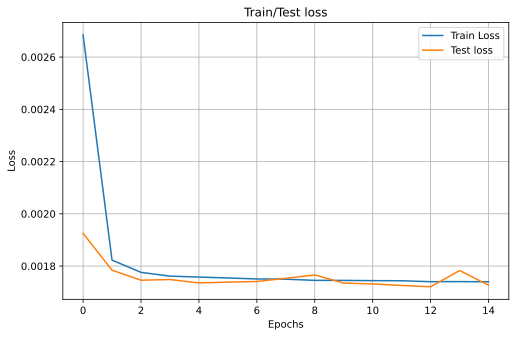

In [23]:
# plot the losses
plt.figure(figsize=(8,5))
plt.plot(train_loss,label='Train Loss')
plt.plot(test_loss,label='Test loss')
plt.title('Train/Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [24]:
test_loss

tensor([0.0019, 0.0018, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0018, 0.0018,
        0.0017, 0.0017, 0.0017, 0.0017, 0.0018, 0.0017])

In [25]:
# test the model for a radom data in test set
net.eval()
X,y = next(iter(test_loader))
with torch.no_grad():
    yHat = net(X)

In [26]:
random_list = []

for i in range(13389):
    random_list.append(np.random.choice(26777))

In [27]:
# take the random 13389 (50% of 26777) rows of both y, yHat and check the correlation
yHat_list = [yHat[i].tolist() for i in random_list]
y_list = [y[i].tolist() for i in random_list]

# we make the arrays 
y_array = np.array(y_list)
yHat_array = np.array(yHat_list)

In [28]:
# pearson's correlation
correlation_coefficient = np.corrcoef(y_list, yHat_list)[0, 1]
correlation_coefficient

0.9446751437605678

In [29]:
mean_actual = np.mean(y_array)

# Calculate the total sum of squares (TSS)
tss = np.sum((y_array - mean_actual)**2)

# Calculate the residual sum of squares (RSS)
rss = np.sum((y_array - yHat_array)**2)

# Calculate R-squared
r_squared = 1 - (rss / tss)

print("R-squared value:", r_squared)

R-squared value: 0.9602141053028527


In [30]:
loss = train_loss[14].item()
correlation_coefficient = float(correlation_coefficient)
r_squared = float(r_squared)

In [31]:
# the metrics obtained finally can be summerised as a dataframe:
dicti = {'Training Loss':loss,'Test Loss':test_loss[14].item(), 
                           'pearsons corelation coeff':correlation_coefficient,
                          'R-square':r_squared}

result_df = pd.Series(dicti)

result_df

Training Loss                0.001740
Test Loss                    0.001727
pearsons corelation coeff    0.944675
R-square                     0.960214
dtype: float64

In [32]:
# Any improvement?

## Classification task 
### predicting the bitvectors using the 15 given properties

In [122]:
# we take the properties as input and the bit vectors as labels

cat_input = norm_data_array
cat_label = fingerprint_array

In [123]:
# prepare the data as dataloaders
data = torch.tensor(cat_input.T).float()
labels = torch.tensor(cat_label.T).float()

train_data,test_data,train_labels,test_labels = train_test_split(data,labels,test_size=0.2)

train_data = TensorDataset(train_data,train_labels)
test_data = TensorDataset(test_data,test_labels)

batchsize = 50
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [124]:
# create the Classification model
def createTheClassNet():
    
    class ClassNet(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.input = nn.Linear(15,100)
            
            self.fc1 = nn.Linear(100,100)
            self.fc2 = nn.Linear(100,100)
            
            self.output = nn.Linear(100,n_bits)
            
            self.relu = nn.ReLU()
            self.sigmoid = nn.Sigmoid()
            
        def forward(self,x):
            
            x = self.relu(self.input(x))
            x = self.relu(self.fc1(x))
            x = self.relu(self.fc2(x))
            x = self.sigmoid(self.output(x))
            return x
        
    net = ClassNet()
        
    lossfun = nn.BCELoss()
        
    optimizer = torch.optim.Adam(net.parameters(),lr=0.001,weight_decay=.001)
        
    return net,lossfun,optimizer

In [125]:
# just a test whether everything is right 

net,lossfun,optimizer = createTheClassNet()

for batch in train_loader:
    X, y = batch

yHat = net(X)
loss = lossfun(yHat,y)

threshold = 0.5
binary_predictions = (yHat >= threshold).float()

# Calculate the test accuracy 
accuracy = torch.sum(binary_predictions == y).item() / (n_bits * len(y))

print(yHat)
print(binary_predictions)
print('Loss:')
print(loss)
print('Accuracy:')
print(accuracy)

tensor([[0.4996, 0.4677, 0.4721,  ..., 0.5151, 0.4915, 0.5106],
        [0.4992, 0.4678, 0.4723,  ..., 0.5150, 0.4914, 0.5108],
        [0.4996, 0.4676, 0.4721,  ..., 0.5152, 0.4917, 0.5106],
        ...,
        [0.5005, 0.4672, 0.4723,  ..., 0.5157, 0.4920, 0.5100],
        [0.4998, 0.4675, 0.4714,  ..., 0.5164, 0.4914, 0.5094],
        [0.4989, 0.4686, 0.4715,  ..., 0.5160, 0.4906, 0.5099]],
       grad_fn=<SigmoidBackward0>)
tensor([[0., 0., 0.,  ..., 1., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 1.],
        ...,
        [1., 0., 0.,  ..., 1., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 1.]])
Loss:
tensor(0.6985, grad_fn=<BinaryCrossEntropyBackward0>)
Accuracy:
0.45625


In [126]:
# code for training the model

numepochs = 15

def function2TrainTheClassModel():
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net,lossfun,optimizer = createTheClassNet()
    net.to(device)
    threshold = 0.5
    
    trainAcc = []
    testAcc = []
    losses = []
    
    for epochi in range(numepochs):
        
        net.train()
        
        batchAcc = []
        batchLoss = []
        
        for X,y in train_loader:
            X,y = X.to(device),y.to(device)
            yHat = net(X)
            
            loss = lossfun(yHat,y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchLoss.append(loss.item())
            binary_predictions = (yHat >= threshold).float()
            accuracy = torch.sum(binary_predictions == y).item() / (1024 * len(y))
            batchAcc.append(accuracy)
            
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))
        
        print(f"Epoch:[{epochi+1}/{numepochs}]\n Loss:{losses[epochi]:.4f}")
        
        X,y = next(iter(test_loader))
        X,y = X.to(device),y.to(device)
        net.eval()
        with torch.no_grad():
            yHat = net(X) 
        binary_predictions = (yHat >= threshold).float()
        accuracy = torch.sum(binary_predictions == y).item() / (1024 * len(y))
        testAcc.append(accuracy)
        
    print("Training complete!")
        
    return trainAcc,testAcc,losses,net,lossfun,optimizer

In [127]:
# train the model
trainAcc,testAcc,losses,net,lossfun,optimizer = function2TrainTheClassModel()

Epoch:[1/15]
 Loss:0.6322
Epoch:[2/15]
 Loss:0.6309
Epoch:[3/15]
 Loss:0.6298
Epoch:[4/15]
 Loss:0.6263
Epoch:[5/15]
 Loss:0.6243
Epoch:[6/15]
 Loss:0.6238
Epoch:[7/15]
 Loss:0.6236
Epoch:[8/15]
 Loss:0.6235
Epoch:[9/15]
 Loss:0.6234
Epoch:[10/15]
 Loss:0.6234
Epoch:[11/15]
 Loss:0.6234
Epoch:[12/15]
 Loss:0.6233
Epoch:[13/15]
 Loss:0.6232
Epoch:[14/15]
 Loss:0.6232
Epoch:[15/15]
 Loss:0.6231
Training complete!


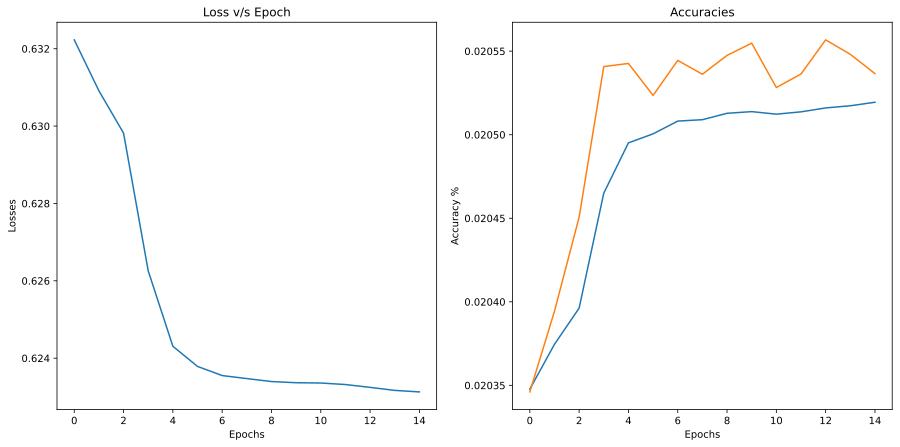

In [128]:
# visualise the model performance
fig,ax = plt.subplots(1,2,figsize=(15,7))

ax[0].plot(losses)
ax[0].set_title('Loss v/s Epoch')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Losses')

ax[1].plot(trainAcc,label='TrainAcc')
ax[1].plot(testAcc,label='TestAcc')
ax[1].set_title('Accuracies')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy %')

plt.show()

In [129]:
# test the model for a random test data
net.eval()
X,y = next(iter(test_loader))
with torch.no_grad():
    yHat = net(X)
    
threshold = 0.5
binary_predictions = (yHat >= threshold).float()

# Calculate the test accuracy
accuracy = torch.sum(binary_predictions == y).item() / (n_bits * len(y))

print(yHat)
print(binary_predictions)
loss = lossfun(yHat,y)
print('Loss:')
print(loss)
print('Accuracy:')
print(accuracy)

tensor([[0.2591, 0.9057, 0.5831,  ..., 0.5496, 0.9389, 0.1975],
        [0.3115, 0.8362, 0.5799,  ..., 0.5114, 0.8709, 0.2636],
        [0.3721, 0.7129, 0.5892,  ..., 0.4488, 0.7134, 0.3529],
        ...,
        [0.3722, 0.7175, 0.5842,  ..., 0.4573, 0.7236, 0.3505],
        [0.3691, 0.7233, 0.5850,  ..., 0.4581, 0.7305, 0.3465],
        [0.4019, 0.6461, 0.5877,  ..., 0.4300, 0.6244, 0.3958]])
tensor([[0., 1., 1.,  ..., 1., 1., 0.],
        [0., 1., 1.,  ..., 1., 1., 0.],
        [0., 1., 1.,  ..., 0., 1., 0.],
        ...,
        [0., 1., 1.,  ..., 0., 1., 0.],
        [0., 1., 1.,  ..., 0., 1., 0.],
        [0., 1., 1.,  ..., 0., 1., 0.]])
Loss:
tensor(0.6218)
Accuracy:
0.6571696325204467


In [130]:
binary_predictions[0].numpy()

array([0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.],
      dtype=float32)

In [110]:
string_list = [str(int(i)) for i in y[0].numpy()]
string = ''
for i in string_list:
    string += i
    
string
index_location = df.index[df['Fingerprint_vectors'] == string]

index_location

Index(['CC1C(O)C(C)C1(C)C'], dtype='object')

In [111]:
def report_smiles_string(bit_vector):
    
    bit_vector = bit_vector.numpy()
    string_list = [str(int(i)) for i in bit_vector]
    string = ''
    for i in string_list:
        string += i
    
    index_location = df.index[df['Fingerprint_vectors'] == string]
    
    return index_location

In [137]:
print(report_smiles_string(binary_predictions[2]) == report_smiles_string(y[2]) )

[False]


In [54]:
index_location = df.index[df['Fingerprint_vectors'] == '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000']
index_location.tolist()[0]

'C'

In [41]:
print(classification_report(y,binary_predictions))

C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       139
           1       0.00      0.00      0.00      3249
           2       0.00      0.00      0.00       243
           3       0.00      0.00      0.00       266
           4       0.00      0.00      0.00      1090
           5       0.00      0.00      0.00       883
           6       0.00      0.00      0.00       144
           7       0.00      0.00      0.00       210
           8       0.00      0.00      0.00       186
           9       0.00      0.00      0.00       162
          10       0.00      0.00      0.00       636
          11       0.00      0.00      0.00       490
          12       0.00      0.00      0.00        94
          13       0.00      0.00      0.00       532
          14       0.00      0.00      0.00       131
          15       0.00      0.00      0.00       165
          16       0.00      0.00      0.00       256
          17       0.00    

In [ ]:
def bit_vector_to_smiles(bit_vector):
    
    bv = Chem.DataStructs.ExplicitBitVect(1024)
    bv.SetBitsFromList([i for i, bit in enumerate(bit_vector) if bit])
    
    mol = Chem.MolFromSmiles('')
    
    mol.SetProp("_MolWt","O")
    AllChem.SetM

In [42]:
# Queries:

# Is the model even right? Do the predictions make sense? 

## Clustering task
### clustering the given species using the 15 properties given

In [45]:
# # use k-means clustering with pca for analyzing the results

# n_clusters = 4

# kmeans = KMeans(n_clusters=n_clusters,random_state=42)
# cluster_labels = kmeans.fit_predict(norm_data_array.T)

# pca = PCA(n_components=2)
# data_pca = pca.fit_transform(norm_data_array.T)

# plt.figure(figsize=(8,6))
# for cluster in np.unique(cluster_labels):
#     plt.scatter(data_pca[cluster_labels == cluster, 0], data_pca[cluster_labels == cluster, 1], label=f'cluster {cluster}')
    
# plt.title('K-Means Clustering Result')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.legend()
# plt.show()

### Hyperparameter Tuning (Next...)

In [44]:
def createTheMolNet(nUnits,nLayers):
    
    class molNet(nn.Module):
        def __init__(self,nUnits,nLayers):
            super().__init__()
            
            self.layers = nn.ModuleDict()
            self.nLayers = nLayers
            
            self.layers['input'] = nn.Linear(1024,nUnits)
            
            for i in range(nLayers):
                self.layers[f'hidden {i}']= nn.Linear(nUnits,nUnits)
                
            self.layers['output'] = nn.Linear(nUnits,3)
            
        def forward(self,x):
            
            x = self.layers['input'](x)
            
            for i in range(self.nLayers):
                x = F.relu(self.layers[f'hidden {i}'](x))
                
            x = self.layers['output'](x)
            return x
        
    net = molNet(nUnits,nLayers)
        
    lossfun = nn.MSELoss()
        
    optimizer = torch.optim.Adam(net.parameters(),lr=0.01,weight_decay=.05)
        
    return net,lossfun,optimizer

def function2TrainTheModel(nUnits,nLayers):
    
    net,lossfun,optimizer = createTheMolNet(nUnits,nLayers)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)
    
    numepochs = 30
    
    training_losses = torch.zeros(numepochs)
    
    for epochi in range(numepochs):
        
        net.train()
        batchLoss = []
        
        for X,y in train_loader:
            
            X,y = X.to(device), y.to(device)
        
            yHat = net(X)
            
            loss = lossfun(yHat,y)
            batchLoss.append(loss.item())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        training_losses[epochi] = np.mean(batchLoss)
        
        print(f"Epoch:[{epochi+1}/{numepochs}]\n Loss:{training_losses[epochi]:.4f}")
    
    print("Test Training complete!")
    
    net.eval()
    test_loss = 0

    with torch.no_grad():
        for X, y in test_loader:
            yHat = net(X)
            loss = lossfun(yHat,y)
            test_loss += loss.item()
        average_test_loss = test_loss / len(test_loader)
        print(f"Test Loss: {average_test_loss:.4f}")
    
    return training_losses[-1],average_test_loss,net

numlayers = [1,5,10,15,20]
numunits = np.arange(50,200,50)

losses = np.zeros((2,len(numunits),len(numlayers)))

for layeridx in range(len(numlayers)):
    for unitidx in range(len(numunits)):
     
        training_loss,test_loss,net = function2TrainTheModel(numunits[unitidx],numlayers[layeridx])
        losses[0,unitidx,layeridx] = np.mean(training_loss[-5:])
        
        print(f'Finished units {unitidx+1}/{len(numunits)} and layers {layeridx+1}/{len(numlayers)}')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (50x15 and 1024x50)

In [10]:
def f(a):
    a = a - np.reshape([3.5],1)
    b = a - np.reshape([2.5],1)
    return [a,b]

a = np.array([10])
f(a)
# prints [[6.5, 7.5]]

b = np.array([[5, 3, 0], [0, 2, 6]])
f(b)
# [[[ 1.5  2.5]
#  [-0.5  0.5]
#  [-3.5 -2.5]]

# [[-3.5 -2.5]
#  [-1.5 -0.5]
#  [ 2.5  3.5]]]

[array([[ 1.5, -0.5, -3.5],
        [-3.5, -1.5,  2.5]]),
 array([[-1., -3., -6.],
        [-6., -4.,  0.]])]

In [7]:
import scipy

data = np.array([1.2, 0.9, 1.3, 1.0, 1.3])
sigma_x = np.sqrt(np.var(data,ddof=1))
mean = np.mean(data)

T = scipy.stats.t.ppf(0.975,len(data)-1)
v_width = T*sigma_x / np.sqrt(len(data))

# print(v_width)
# print(mean)
print(f'{mean:.2f} +/- {v_width:.2f} with 95% confidence')

1.14 +/- 0.23 with 95% confidence


In [8]:
%%writefile test.py

def hello_world():
    print('Hello world')

Writing test.py


In [9]:
import test

test.hello_world()

Hello world


In [11]:
%%HTML

<h3 class="grab-me"> Hola Senores </h3>

In [12]:
%%javascript

var grabme = document.querySelector('.grab-me');
grabme.textContent = 'Hoopla';

<IPython.core.display.Javascript object>

In [13]:
from statsmodels.formula.api import ols

x1 = [1, 1, -1, -1]
x2 = [1, -1, 1, -1]
y = [1.2, 3.2, 4.1, 3.6]

data = {'x1':x1, 'x2':x2, 'y':y}

model = ols('y ~ x1 + x2', data=data).fit()
model.summary()

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     1.051
Date:                Wed, 13 Dec 2023   Prob (F-statistic):              0.568
Time:                        18:31:49   Log-Likelihood:                -3.7957
No. Observations:                   4   AIC:                             13.59
Df Residuals:                       1   BIC:                             11.75
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0250      0.625      4.840      0.130      -4.916      10.966
x1            -0.8250      0.625     -1.320      0.413      -8.766       7.116
x2            -0.3750      0.625     -0.600      0.656      -8.316       7.566
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.000
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.667
Skew:                           0.000   Prob(JB):                        0.717
Kurtosis:                       1.000   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
!set CUDA_VISIBLE_DEVICES=0

In [23]:
import torch
torch.device("cuda:0")

device(type='cuda', index=0)

In [24]:
torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cpu')

In [25]:
torch.cuda.is_available(), torch.cuda.device_count()

(False, 0)